In [61]:
import sys
import regions
#import pyavm
import numpy as np
import PIL

from regions import Regions

from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.visualization import simple_norm

import reproject 
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u

from reproject import reproject_interp

from spectral_cube import SpectralCube
from spectral_cube import Projection

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils import background

import regions
import cv2

from astropy.visualization.wcsaxes import add_scalebar
from astropy.visualization.wcsaxes import add_beam

import random as rand

from astropy.table import Table, QTable
from astropy.io import ascii

from astroquery.vizier import Vizier

In [15]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [16]:
from jwst_plots import make_cat_use
from jwst_plots import JWSTCatalog
import cutout_manager as cm
import extinction as ex
import moment_maker as mm
import catalog_query as cq


In [17]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [ ]:
clump1 = SkyCoord('17:46:19.2287619119', '-28:38:29.2978617171', unit=(u.hourangle, u.deg))
clump2 = SkyCoord('17:46:19.5945777603', '-28:38:09.9402161687', unit=(u.hourangle, u.deg))

# Querying catalog of mm sources for filament sources

In [68]:
#cat_ = ascii.read('https://cdsarc.cds.unistra.fr/ftp/J/ApJS/234/22/table4.dat', readme="https://cdsarc.cds.unistra.fr/ftp/J/ApJS/234/22/ReadMe")
cat_ = Table.read('/orange/adamginsburg/jwst/cloudc/catalogs/table4.dat', format='ascii', delimiter='\t')
cat_

Name,GLON,GLAT,GLONc,GLATc,Reff,Speak,e_Speak,Sint,e_Sint,SNR,C,CCO
str15,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64
G000.004-00.025,0.004,-0.025,359.999,-0.025,43,1.11,0.04,8.15,0.06,30.3,0.7,67
G000.006+00.156,0.006,0.156,0.005,0.157,59,1.2,0.04,7.73,0.11,33.7,0.86,20
G000.006+00.048,0.006,0.048,0.005,0.049,24,0.33,0.03,1.29,0.01,10.1,0.48,73
G000.007+00.274,0.007,0.274,0.005,0.272,42,0.26,0.05,2.44,0.11,5.3,0.6,--
G000.007+00.114,0.007,0.114,0.009,0.12,34,0.41,0.03,2.68,0.03,11.9,0.55,28
G000.007+00.091,0.007,0.091,0.007,0.093,23,0.24,0.03,0.64,0.01,7.2,0.61,63
G000.009+00.059,0.009,0.059,0.013,0.066,33,0.34,0.03,1.85,0.03,10.4,0.62,54
G000.011-00.258,0.011,-0.258,0.006,-0.262,14,0.21,0.04,0.24,0.01,5.8,0.53,--
G000.014+00.020,0.014,0.02,0.008,0.02,31,0.52,0.03,3.17,0.03,15.0,0.53,61


In [118]:
source = cat_[cat_['Name'] == 'G000.338+00.025']
center = SkyCoord(source['GLON'], source['GLAT'], unit=(u.deg, u.deg), frame='galactic')
source_reg = regions.CircleSkyRegion(center[0], radius=source['Reff'][0]*u.arcsec)
source

Name,GLON,GLAT,GLONc,GLATc,Reff,Speak,e_Speak,Sint,e_Sint,SNR,C,CCO
str15,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64
G000.338+00.025,0.338,0.025,0.339,0.026,29,0.34,0.05,1.6,0.05,7.1,0.58,18


In [73]:
scuba_coords = SkyCoord(cat_['GLON'], cat_['GLAT'], unit=(u.deg, u.deg), frame='galactic')

# Plotting Positions of mm sources

In [70]:
cutout_c1 = cm.Cutout(clump1, 30*u.arcsec, 30*u.arcsec)
cutout_c2 = cm.Cutout(clump2, 30*u.arcsec, 30*u.arcsec)

reg_c1 = regions.RectangleSkyRegion(clump1, width=30*u.arcsec, height=30*u.arcsec)
reg_c2 = regions.RectangleSkyRegion(clump2, width=30*u.arcsec, height=30*u.arcsec)

In [11]:
cutout_B3_c1 = cutout_c1.get_alma_B3()
cutout_B3_c2 = cutout_c2.get_alma_B3()

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [77]:
scuba_c1 = scuba_coords[reg_c1.contains(scuba_coords, cutout_B3_c1.wcs)]
scuba_c2 = scuba_coords[reg_c2.contains(scuba_coords, cutout_B3_c2.wcs)]

In [86]:
scuba_c2.icrs.ra

<Longitude [266.58132388] deg>

/scratch/local/55363331/ipykernel_554340/2494916370.py:4: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(scuba_c1.icrs.ra, scuba_c1.icrs.dec, transform=ax.get_transform('world'), s=100, edgecolor='white', facecolor='none', lw=2, marker='x')


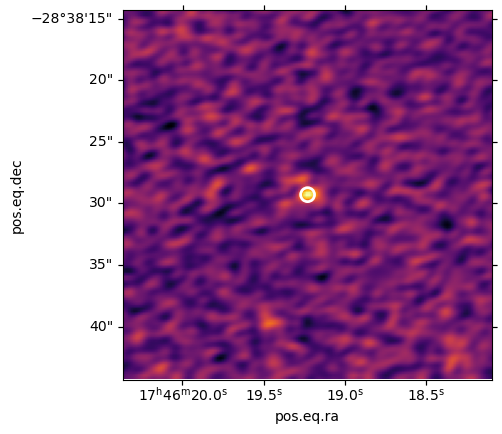

In [101]:
ax = plt.subplot(projection=cutout_B3_c1.wcs)
ax.imshow(cutout_B3_c1.data, origin='lower', cmap='inferno')
ax.scatter(clump1.ra.deg, clump1.dec.deg, transform=ax.get_transform('world'), s=100, edgecolor='white', facecolor='none', lw=2)
ax.scatter(scuba_c1.icrs.ra, scuba_c1.icrs.dec, transform=ax.get_transform('world'), s=100, edgecolor='white', facecolor='none', lw=2, marker='x')

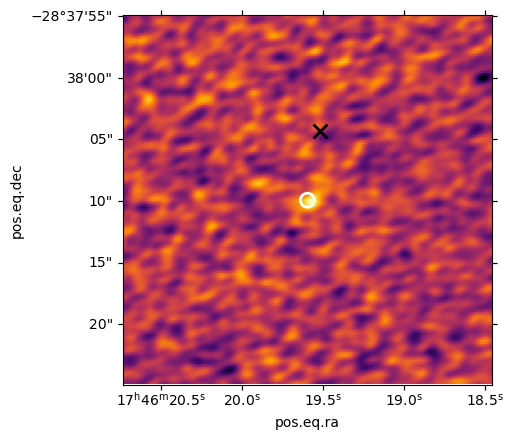

In [120]:
ax = plt.subplot(projection=cutout_B3_c2.wcs)
ax.imshow(cutout_B3_c2.data, origin='lower', cmap='inferno')
ax.scatter(clump2.ra.deg, clump2.dec.deg, transform=ax.get_transform('world'), s=100, edgecolor='white', facecolor='none', lw=2)
ax.scatter(scuba_c2.icrs.ra, scuba_c2.icrs.dec, transform=ax.get_transform('world'), s=100, lw=2, marker='x', color='k')

In [91]:
pos_ctr = SkyCoord('17:46:20.8194569665', '-28:37:52.4236707380', unit=(u.hourangle, u.deg), frame='icrs')
size_filabox = (2.6762805138*u.arcmin, 86.6778672344*u.arcsec)
l = size_filabox[0]
w = size_filabox[1] 
reg_filabox = regions.RectangleSkyRegion(center=pos_ctr, width=size_filabox[1], height=size_filabox[0])

In [122]:
scuba_filabox = scuba_coords[reg_filabox.contains(scuba_coords, cutout_B3_c1.wcs)]
scuba_cat_filabox = cat_[reg_filabox.contains(scuba_coords, cutout_B3_c1.wcs)]

In [124]:
regions_scuba = []

for i in range(len(scuba_filabox)):
    regions_scuba.append(regions.CircleSkyRegion(scuba_filabox[i], radius=source['Reff'][0]*u.arcsec))

In [94]:
cutout_filabox = cm.Cutout(pos_ctr, size_filabox[0], size_filabox[1])
cutout_filabox_B3 = cutout_filabox.get_alma_B3()
cutout_filabox_rgb, cutout_filabox_rgb_wcs = cutout_filabox.get_cutout_rgb()

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


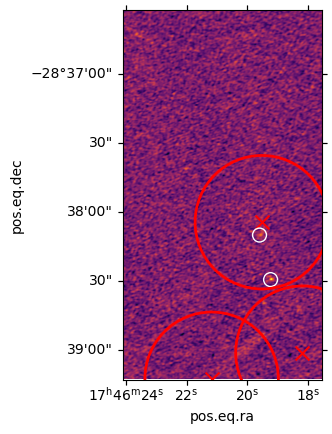

In [126]:
ax = plt.subplot(projection=cutout_filabox_B3.wcs)
ax.imshow(cutout_filabox_B3.data, origin='lower', cmap='inferno')
ax.scatter(scuba_filabox.icrs.ra, scuba_filabox.icrs.dec, transform=ax.get_transform('world'), s=100, marker='x', color='red')
#source_reg.to_pixel(cutout_filabox_B3.wcs).plot(ax=ax, edgecolor='red', facecolor='none', lw=2)
ax.scatter(clump1.ra, clump1.dec, transform=ax.get_transform('world'), s=100, edgecolor='white', facecolor='none')
ax.scatter(clump2.ra, clump2.dec, transform=ax.get_transform('world'), s=100, edgecolor='white', facecolor='none')

for reg in regions_scuba:
    reg.to_pixel(cutout_filabox_B3.wcs).plot(ax=ax, edgecolor='red', facecolor='none', lw=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


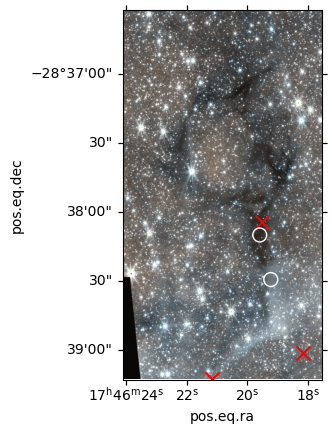

In [98]:
ax = plt.subplot(projection=cutout_filabox_rgb_wcs)
ax.imshow(cutout_filabox_rgb, origin='lower')
ax.scatter(scuba_filabox.icrs.ra, scuba_filabox.icrs.dec, transform=ax.get_transform('world'), s=100, marker='x', color='red')
ax.scatter(clump1.ra, clump1.dec, transform=ax.get_transform('world'), s=100, edgecolor='white', facecolor='none')
ax.scatter(clump2.ra, clump2.dec, transform=ax.get_transform('world'), s=100, edgecolor='white', facecolor='none')